In [1]:
!apt-get install -y tesseract-ocr tesseract-ocr-ben poppler-utils
!pip install pytesseract pdf2image sentence-transformers faiss-cpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  poppler-utils tesseract-ocr-ben
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 702 kB of archives.
After this operation, 1,568 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ben all 1:4.00~git30-7274cfa-1.1 [516 kB]
Fetched 702 kB in 1s (1,148 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Selecting previously unselected package tesseract-ocr-ben.
Preparing to unpack .../t

In [2]:
import pandas as pd
import torch
import os
import faiss
import numpy as np
import pickle
import openai
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration
from openai import OpenAI
from torch.nn.functional import softmax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f">>We are using {device} device.<<")

>>We are using cuda device.<<


In [4]:
from google.colab import files
uploaded = files.upload()


Saving HSC26-Bangla1st-Paper.pdf to HSC26-Bangla1st-Paper.pdf


In [5]:
from pdf2image import convert_from_path

pages = convert_from_path("/content/HSC26-Bangla1st-Paper.pdf", dpi=300)
print(f"Total pages: {len(pages)}")

Total pages: 49


In [7]:
import pytesseract
from pdf2image import convert_from_path
import os

# === CONFIG ===
pdf_path = "/content/HSC26-Bangla1st-Paper.pdf"
image_folder = "ocr_images"
text_folder = "ocr_texts"

# === Step 1: Create output directories ===
os.makedirs(image_folder, exist_ok=True)
os.makedirs(text_folder, exist_ok=True)

# === Step 2: Convert PDF pages to images ===
pages = convert_from_path(pdf_path, dpi=300)

# === Step 3: Save images and extract text ===
for i, page in enumerate(pages):
    image_path = os.path.join(image_folder, f"page_{i+1}.png")
    text_path = os.path.join(text_folder, f"output_{i+1}.txt")

    page.save(image_path, "PNG")

    # Apply Tesseract OCR with Bengali language
    text = pytesseract.image_to_string(image_path, lang='ben')

    # Save OCR text
    with open(text_path, "w", encoding="utf-8") as f:
        f.write(text)

    print(f"Processed page {i+1}")


Processed page 1
Processed page 2
Processed page 3
Processed page 4
Processed page 5
Processed page 6
Processed page 7
Processed page 8
Processed page 9
Processed page 10
Processed page 11
Processed page 12
Processed page 13
Processed page 14
Processed page 15
Processed page 16
Processed page 17
Processed page 18
Processed page 19
Processed page 20
Processed page 21
Processed page 22
Processed page 23
Processed page 24
Processed page 25
Processed page 26
Processed page 27
Processed page 28
Processed page 29
Processed page 30
Processed page 31
Processed page 32
Processed page 33
Processed page 34
Processed page 35
Processed page 36
Processed page 37
Processed page 38
Processed page 39
Processed page 40
Processed page 41
Processed page 42
Processed page 43
Processed page 44
Processed page 45
Processed page 46
Processed page 47
Processed page 48
Processed page 49


In [8]:
import re

def clean_bangla_text(text):
    # Remove unwanted characters (non-Bangla, non-punctuation, non-space)
    text = re.sub(r'[^\u0980-\u09FF\s।,?!\n]+', '', text)
    # Normalize excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [10]:
import re

def clean_bangla_text(text):
    # Remove unwanted characters (non-Bangla, non-punctuation, non-space)
    text = re.sub(r'[^\u0980-\u09FF\s।,?!\n]+', '', text)
    # Normalize excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

output_dir = "/content/ocr_texts"  # or specify full path like "./ocr_texts/"

# Fix: Iterate from 1 to len(pages) inclusive to match the file names
for i in range(1, len(pages) + 1):
    input_file = os.path.join(output_dir, f"output_{i}.txt")
    output_file = os.path.join(output_dir, f"cleaned_output_{i}.txt")

    # Read original OCR text
    with open(input_file, "r", encoding="utf-8") as f:
        raw_text = f.read()

    # Clean it
    cleaned_text = clean_bangla_text(raw_text)

    # Save cleaned version
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(cleaned_text)

    print(f"✅ Cleaned: {input_file} → {output_file}")

✅ Cleaned: /content/ocr_texts/output_1.txt → /content/ocr_texts/cleaned_output_1.txt
✅ Cleaned: /content/ocr_texts/output_2.txt → /content/ocr_texts/cleaned_output_2.txt
✅ Cleaned: /content/ocr_texts/output_3.txt → /content/ocr_texts/cleaned_output_3.txt
✅ Cleaned: /content/ocr_texts/output_4.txt → /content/ocr_texts/cleaned_output_4.txt
✅ Cleaned: /content/ocr_texts/output_5.txt → /content/ocr_texts/cleaned_output_5.txt
✅ Cleaned: /content/ocr_texts/output_6.txt → /content/ocr_texts/cleaned_output_6.txt
✅ Cleaned: /content/ocr_texts/output_7.txt → /content/ocr_texts/cleaned_output_7.txt
✅ Cleaned: /content/ocr_texts/output_8.txt → /content/ocr_texts/cleaned_output_8.txt
✅ Cleaned: /content/ocr_texts/output_9.txt → /content/ocr_texts/cleaned_output_9.txt
✅ Cleaned: /content/ocr_texts/output_10.txt → /content/ocr_texts/cleaned_output_10.txt
✅ Cleaned: /content/ocr_texts/output_11.txt → /content/ocr_texts/cleaned_output_11.txt
✅ Cleaned: /content/ocr_texts/output_12.txt → /content/ocr_te

In [12]:
with open("all_cleaned_text.txt", "w", encoding="utf-8") as merged:
    for i in range(1, len(pages) + 1):
        with open(f"/content/ocr_texts/cleaned_output_{i}.txt", "r", encoding="utf-8") as f:
            merged.write(f.read() + "\n\n")

In [14]:
with open("all_cleaned_text.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=100,
    separators=["\n\n", "\n", "।", " ", ""]
)

In [16]:
chunks = text_splitter.split_text(raw_text)

In [17]:
print(f"✅ Total chunks created: {len(chunks)}\n")
for i, chunk in enumerate(chunks[:3]):
  print(f"--- Chunk {i+1} ---\n{chunk[:400]}...\n")

✅ Total chunks created: 131

--- Chunk 1 ---
অনলাইন ব্যাট হি বাংলা ইংরেজি আইসিটি অনলাইন ব্যাচ সম্পর্কিত যেকোনো জিজ্ঞাসায়, ,...

--- Chunk 2 ---
লুল জআললাইন ব্যাচ ১? নিম্নবিত্ত ব্যক্তির হঠাৎ বিত্তশালী হয়ে ওঠার ফলে সমাজে পরিচয় সংকট সম্পর্কে ধারণা লাভ করবে। ৮ তৎকালীন সমাজসভ্যতা ও মানবতার অবমাননা সম্পর্কে জানতে পারবে। ৮ তৎকালীন সমাজের পণপ্রথার কুপ্রভাব সম্পর্কে জানতে পারবে। ৮ তৎকালে সমাজে ভদ্রলোকের স্বভাববৈশিষ্ট্য সম্পর্কে জ্ঞানলাভ করবে৷ ৮ নারী কোমল ঠিক, কিন্তু দুর্বল নয় কল্যাণীর জীবনচরিত দ্বারা প্রতিষ্ঠিত এই সত্য অনুধাবন করতে পারবে। ৮ মান...

--- Chunk 3 ---
। পিতৃহীন দীপুর চাচাই ছিলেন পরিবারের কর্তা। দীপু শিক্ষিত হলেও তার সিদ্ধান্ত নেওয়ার ক্ষমতা ছিল না। চাচা তার বিয়ের উদ্যোগ নিলেও যৌতুক নিয়ে বাড়াবাড়ি করার কারণে কন্যার পিতা অপমানিত বোধ করে বিয়ের আলোচনা ভেঙে দেন। দীপু মেয়েটির ছবি দেখে মুগ্ধ হলেও তার চাচাকে কিছুই বলতে পারেননি। ৩। দীপুর চাচার সঙ্গে অপরিচিতা গন্সের কোন চরিত্রের মিল আছে? ক হরিশের খ মামার গ শিক্ষকের ঘ বিনুর ৪ উক্ত চরিত্রে প্রাধান্য প...



In [18]:
df_filtered = pd.DataFrame({"Text": chunks})

# Save for manual translation or review
df_filtered.to_csv("bangla_text.csv", index=False, encoding="utf-8-sig")


In [ ]:
##Clean the CSV for more Clearence and named 10MS

In [77]:
df = pd.read_csv('/content/10ms - Sheet1 (2).csv')
df['word_count'] = df['Text'].astype(str).apply(lambda x: len(x.split()))

df_filtered = df[df['word_count'] <= 600].copy()
df_filtered = df_filtered.reset_index(drop=True)

In [78]:
df_filtered['Text'][7]


'বিনুদা ফিরিয়া আসিয়া বলিলেন,মন্দ নয় হে খাটি সোনা বটে বিনুদাদার ভাষাটা অত্যন্ত আঁট যেখানে আমরা বলি চমৎকার সেখানে তিনি বলেন চলনসই অতএব বুঝিলাম আমার ভাগ্যে প্রজাপতির সঙ্গে পঞ্চশরের কোনো বিরোধ নাই বলা বাহুল্য বিবাহ উপলক্ষে কন্যাপক্ষকেই কলকাতা আসিতে হইল কন্যার পিতা শস্তুনাথবাবু হরিশকে কত বিশ্বাস করেন তাহার প্রমাণ এই যে বিবাহের তিন দিন পূর্বে তিনি আমাকে চক্ষে দেখেন এবং আশীর্বাদ করিয়া যান বয়স তার চল্লিশের কিছু এপারে বা ওপারে চুল কীচা গোঁফে পাক ধরিতে আরম্ভ করিয়াছে মাত্র সুপুরুষ বটে ভিড়ের মধ্যে দেখিলে সকলের আগে তার উপরে চোখ পড়িবার মতো চেহারা আশা করি আমাকে দেখিয়া তিনি খুশি হইয়াছিলেন বোঝা শক্ত কেননা তিনি বড়ই চুপচাপ যে দুটি একটি কথা বলেন তাহাতে যেন পুরা জোর দেন না মামার মুখ তখন অনর্গল ছুটিতেছিল ধনে মানে আমাদের স্থান শহরের কারো চেয়ে কম নয় এই কথাই তিনি নানা প্রসঙ্গে প্রচার করিতেছিলেন শস্তুনাথবাবু কোনো ফাঁকে হু হ্যা কিছুই বলেননি মামাকে দমানো শক্ত তিনি শস্তুনাথবাবুর চুপ ভাব দেখে ভাবিলেন লোকটা নিতান্ত নিজীব একেবারে কোনো তেজ নাই বেহাইসম্পদায়ে তেজ থাকাটা দোষের অতএব মামা মনে মনে খুশি হইলেন শ

In [79]:
tokenizer_for_embeddings = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model_for_embeddings = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device)

In [80]:
!pip install -q scikit-learn matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [81]:
vectorizer = TfidfVectorizer().fit_transform(chunks)
cos_sim_matrix = cosine_similarity(vectorizer)

In [82]:
adj_similarities = [cos_sim_matrix[i, i+1] for i in range(len(chunks) - 1)]

In [83]:
print(f"🔍 Avg similarity between adjacent chunks: {sum(adj_similarities)/len(adj_similarities):.3f}")
print("⬇️ Lowest similarity pairs:")
for i, sim in sorted(enumerate(adj_similarities), key=lambda x: x[1])[:5]:
  print(f"Chunk {i} ↔ Chunk {i+1}: {sim:.3f}")

🔍 Avg similarity between adjacent chunks: 0.295
⬇️ Lowest similarity pairs:
Chunk 103 ↔ Chunk 104: 0.000
Chunk 7 ↔ Chunk 8: 0.068
Chunk 38 ↔ Chunk 39: 0.076
Chunk 47 ↔ Chunk 48: 0.095
Chunk 102 ↔ Chunk 103: 0.104


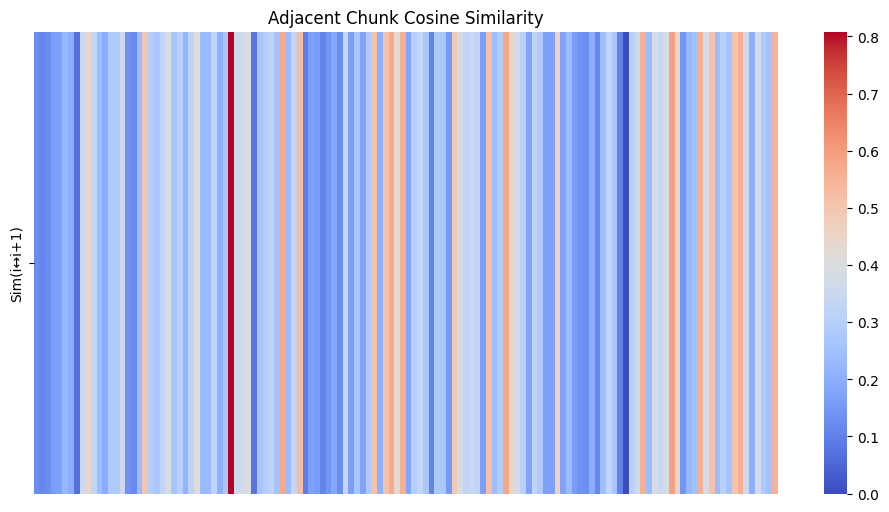

In [84]:
plt.figure(figsize=(12, 6))
sns.heatmap([adj_similarities], cmap='coolwarm', xticklabels=False, yticklabels=["Sim(i↔i+1)"])
plt.title("Adjacent Chunk Cosine Similarity")
plt.show()

In [85]:
def Data_generate_embeddings(text):
    inputs = tokenizer_for_embeddings(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model_for_embeddings(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

articles = df_filtered['Text'].tolist()
article_embeddings = []
for doc in tqdm(articles, desc="Generating Embeddings For All Articles:"):
    article_embeddings.append(Data_generate_embeddings(doc))

Generating Embeddings For All Articles:: 100%|██████████| 54/54 [00:00<00:00, 59.93it/s]


In [86]:
print(f"Dimension: {len(article_embeddings[7])} \nVectors: {article_embeddings[7]}" )

Dimension: 384 
Vectors: [-1.70920581e-01 -1.55876279e-01  2.24563718e-01  2.68188953e-01
  5.47947362e-02  2.64219195e-01 -1.80756718e-01 -9.94288027e-02
  1.72627330e-01 -4.12444592e-01  2.01898515e-01  1.83579594e-01
 -4.34286706e-03 -7.25657791e-02  5.49833067e-02 -3.29408914e-01
  1.06437370e-01  1.28079161e-01 -1.93796039e-01  1.31557152e-01
  6.60928711e-02 -6.44139796e-02 -5.54799587e-02 -4.15268354e-02
  1.58379544e-02  2.65955180e-02 -3.76993179e-01 -2.07289726e-01
 -7.77616501e-02  5.37481345e-03 -2.80924514e-02  1.48185581e-01
 -2.39358604e-01 -3.19862574e-01  7.08468556e-02 -3.57073486e-01
  1.80302650e-01  4.46600199e-01  2.94384956e-01 -3.78886126e-02
  1.70743719e-01 -2.20745519e-01 -3.43275309e-01 -3.72524321e-01
  4.31355089e-02 -2.64227509e-01 -8.14965963e-02  6.71654791e-02
 -4.88458127e-01 -1.29697382e-01 -9.09350067e-02 -1.93886101e-01
  5.04692793e-01 -6.41216785e-02 -2.70333290e-01 -1.54095795e-03
 -1.26978206e-02  1.12472102e-01  3.52656782e-01  1.23806991e-01


In [87]:
with open('embedding.pkl', 'wb') as f:
    pickle.dump(article_embeddings, f)

In [88]:
with open('embedding.pkl', 'rb') as f:
    article_embeddings = pickle.load(f)

In [89]:
dimension = len(article_embeddings[0])
index = faiss.IndexFlatL2(dimension)
index.add(np.array(article_embeddings))

In [90]:
def data_retrieve_documents(query_embedding, k):
    distances, indices = index.search(np.array([query_embedding]), k)
    return indices[0]

In [102]:
question = " লেখক পরিচিতি  প্রকৃত নাম?"
question_embeddings = Data_generate_embeddings(question)

In [103]:
retrieved_articles_indices = data_retrieve_documents(question_embeddings, 3)
retrieved_articles_indices

array([ 2, 40, 39])

In [104]:
model_name = "t5-base"
tokenizer_t5_base = T5Tokenizer.from_pretrained(model_name, legacy=False)
model_t5_base = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
def query_answer_by_t5(question, context, max_length=150):
    input_text = f"question: {question} context: {context}"
    input_ids = tokenizer_t5_base.encode(input_text, return_tensors="pt").to(device)
    outputs = model_t5_base.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True, return_dict_in_generate=True,output_scores=True)
    answer = tokenizer_t5_base.decode(outputs.sequences[0], skip_special_tokens=True)

    logits = torch.stack(outputs.scores, dim=1)
    probabilities = softmax(logits, dim=-1)
    gen_sequence_indices = outputs.sequences[:, 1:].unsqueeze(-1)
    probabilities = probabilities[:, :gen_sequence_indices.shape[1], :]
    generated_token_probs = probabilities.gather(2, gen_sequence_indices).squeeze(-1)
    avg_confidence = generated_token_probs.mean().item()
    return answer, avg_confidence



In [105]:
all_answers = []
for idx in retrieved_articles_indices:
    answer_entry = {}
    answer_entry['question'] = question
    answer_entry['title'] = chunks[idx]  # Use chunks[idx] instead of df_filtered['Text'][idx]
    answer, confidence = query_answer_by_t5(question, chunks[idx]) # Use chunks[idx] here too
    answer_entry['answer'] = answer
    answer_entry['confidence'] = confidence
    all_answers.append(answer_entry)

In [106]:
all_answers

[{'question': ' লেখক পরিচিতি  প্রকৃত নাম?',
  'title': '। পিতৃহীন দীপুর চাচাই ছিলেন পরিবারের কর্তা। দীপু শিক্ষিত হলেও তার সিদ্ধান্ত নেওয়ার ক্ষমতা ছিল না। চাচা তার বিয়ের উদ্যোগ নিলেও যৌতুক নিয়ে বাড়াবাড়ি করার কারণে কন্যার পিতা অপমানিত বোধ করে বিয়ের আলোচনা ভেঙে দেন। দীপু মেয়েটির ছবি দেখে মুগ্ধ হলেও তার চাচাকে কিছুই বলতে পারেননি। ৩। দীপুর চাচার সঙ্গে অপরিচিতা গন্সের কোন চরিত্রের মিল আছে? ক হরিশের খ মামার গ শিক্ষকের ঘ বিনুর ৪ উক্ত চরিত্রে প্রাধান্য পেয়েছে দৌরাত্ম হীনম্মন্যতা লোভ নিচের কোনটি ঠিক? ক।। ও খ। ও গ।ও ঘ।, ও ৫ অনুপমের বয়স কত বছর? ক পঁচিশ খ ছাবিবিশ গ সাতাশ ঘ আটাশ কতগুলো প্রশ্নের সঠিক উত্তর দিতে পারলে?',
  'answer': '',
  'confidence': 0.7877141833305359},
 {'question': ' লেখক পরিচিতি  প্রকৃত নাম?',
  'title': '। এ গল্প নিশ্চয় তারা বিশপঁচিশ বার শনিয়াছে। মেয়েদের কেন যে এত আগ্রহ তাহা বুঝিলাম। সেই সুধাকণ্ঠের সোনার কাঠিতে সকল কথা যে সোনা হইয়া ওঠে। মেয়েটির সমস্ত শরীর মন যে একেবারে প্রাণে ভরা, তার সমস্ত চলায় বলায় স্পর্শে প্রাণ ঠিকরিয়া ওঠে। তাই মেয়েরা যখন তার মুখে গল্প শোনে

In [107]:
highest_conf = -1
for answer in all_answers:
    if highest_conf < answer['confidence']:
        highest_conf = answer['confidence']
        answer_with_reference = answer
answer_with_reference

{'question': ' লেখক পরিচিতি  প্রকৃত নাম?',
 'title': '। এ গল্প নিশ্চয় তারা বিশপঁচিশ বার শনিয়াছে। মেয়েদের কেন যে এত আগ্রহ তাহা বুঝিলাম। সেই সুধাকণ্ঠের সোনার কাঠিতে সকল কথা যে সোনা হইয়া ওঠে। মেয়েটির সমস্ত শরীর মন যে একেবারে প্রাণে ভরা, তার সমস্ত চলায় বলায় স্পর্শে প্রাণ ঠিকরিয়া ওঠে। তাই মেয়েরা যখন তার মুখে গল্প শোনে তখন, গল্প নয়, তাহাকেই শোনে তাহাদের হৃদয়ের উপর প্রাণের ঝর্না ঝরিয়া পড়ে। তার সেই উদ্ভাসিত প্রাণ আমার তুলিল আমার মনে হইল, আমাকে যে প্রকৃতি তাহার আকাশ দিয়া বেষ্টন করিয়াছে সে এ তরুণীরই অক্লান্ত অল্লান প্রাণের বিশ্বব্যাপী বিস্তার।পরের স্টেশনে পৌঁছিতেই খাবারওয়ালাকে ডাকিয়া সে খুব খানিকটা চানামুঠ কিনিয়া লইল এবং লাগিল। আমার প্রকৃতি যে জাল দিয়া বেড়াআমি কেন বেশ সহজে হাসিমুখে মেয়েটির কাছে এই চানা একমুঠো চাহিয়া লইতে পারিলাম না। হাত বাড়াইয়া দিয়া কেন আমার লোভ স্বীকার করিলাম না',
 'answer': '',
 'confidence': 0.8258021473884583}

In [98]:
# Fix: Access chunks directly using the retrieved indices
retrieved_text_articles = [chunks[i] for i in retrieved_articles_indices]

In [99]:
def processing_context(docs, max_tokens=1536):
    processed_docs = []
    total_tokens = 0
    for doc in docs:
        tokens = len(doc.split())
        if total_tokens + tokens <= max_tokens:
            processed_docs.append(doc)
            total_tokens += tokens
        else:
            break
    return "\n".join(f"- {doc}" for doc in processed_docs)

final_retrived_contexts = processing_context(retrieved_text_articles)

In [ ]:
client = OpenAI(api_key='sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
def answer_by_gpt4_turbo(question, contexts, max_tokens):
    prompt = f"""Answer the question based on the provided context. If the context doesn't contain the answer, say "Sorry! I don't have enough information to answer that."
    **Question:** {question}
    **Context:** {contexts}
    """
    messages = [
        {"role": "system", "content": "You are an intelligent assistant that answers questions based on the provided context."},
        {"role": "user", "content": prompt}
    ]
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content

In [109]:
answer_gpt4 = answer_by_gpt4_turbo(question, final_retrived_contexts ,250)
answer_gpt4

"Sorry! I don't have enough information to answer that."